# Sensor Data #

### Setup ###

Import Libraries

In [1]:
import numpy as np
import json as json
import pandas as pd
import math
import datetime
import warnings
warnings.filterwarnings("ignore")
import pylab as pl 
from zoneinfo import ZoneInfo

general settings

In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
#this seems to fix the odd scrolling behavior when charts are present
%matplotlib inline 

In [3]:
# Use dark Background
pl.style.use('dark_background')

In [4]:
# Chart parameters
Cw = 20
Ch = 5
Hs = 0.45

### Functions ###

In [5]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [6]:
def remove_outliers(sensor_data, sigma=0.25):
    """ 
    Eliminate likely sensor errors (outliers outside of sigma). Return Series not containing samples that 
    exceed +- sigma
    """
    # Compute mean and std
    mean = sensor_data.mean()
    std = sensor_data.std()
    # Define thresholds
    lower = mean - sigma * std
    upper = mean + sigma * std
    # Apply mask
    return sensor_data[(sensor_data >= lower) & (sensor_data <= upper)]

### Load Settings ###

In [7]:
config=json.loads(open('settings.json','r').read())

In [8]:
window = config['window'] # length of observation frame (in secs)
sample_rate = config['sample_rate'] # Hz
offset_x = config['offset_x']
offset_y = config['offset_y']
offset_z = config['offset_z'] # run calibrate.py to update this value, with sensor board resting as horizontal as possible
ipmux_addr = config['ipmux_addr']  # destination of NMEA UDP messages 
ipmux_port = config['ipmux_port'] 
pitch_on_y_axis = config['pitch_on_y_axis'] # Rpi oriented with longest side parallel to fore-aft line of vessel (0) or perpendicular (1)

sample_period = 1.0/sample_rate
n = int(window*sample_rate) 
df = float(sample_rate)/float(n)

### User Input ###

Set plot timelines

In [9]:
Short_span = datetime.datetime.now() - datetime.timedelta(hours=24)
Long_span = datetime.datetime.now() - datetime.timedelta(days=2)

## SenseHat Logs ##

In [10]:
# Read CSVs and refactor panda columns
logs = pd.read_csv('log_sec.csv', index_col = False)
logs["datetime"] = pd.to_datetime(logs["timestamp"], unit="s")#.dt.strftime('%Y-%m-%d %H:%M:%S')
logs['pressure'] = logs.pressure.astype(int)
logs.drop(logs[['timestamp','date', 'time']], axis=1, inplace=True)
logs

,temperature,pressure,humidity,avg_pitch,avg_roll,max_pitch,max_roll,wave height,wave period,datetime
0,32,1005,79,0,1,1,3,0.00,0,2025-09-10 07:02:40.539999962
1,32,1005,79,0,1,1,2,0.00,0,2025-09-10 07:05:40.657000065
2,32,1005,79,0,1,1,2,0.00,0,2025-09-10 07:08:40.769999981
3,32,1005,79,0,1,0,2,0.00,0,2025-09-10 07:11:40.887000084
4,32,1005,79,0,1,0,3,0.00,0,2025-09-10 07:14:41.006000042
...,...,...,...,...,...,...,...,...,...,...
306,39,1019,62,1,1,3,5,0.15,9,2025-09-11 01:26:05.016999960
307,39,1019,62,1,1,2,4,0.00,0,2025-09-11 01:29:05.176000118
308,39,1019,62,1,2,3,4,0.00,0,2025-09-11 01:32:05.335999966
309,39,1019,62,1,1,4,4,0.00,0,2025-09-11 01:35:05.506999969


In [11]:
# Reindex on datetime and aggregate by hour
logs.set_index('datetime', inplace=True)
hourly_logs = logs.resample('h').mean()

In [12]:
# Filter on Datetime
logs = logs[logs.index > Short_span]
hourly_logs = hourly_logs[hourly_logs.index > Long_span]

<br><br>
Note: Modify update Short_span and Long_span constants under User Input to modify the chart timelines

### Environmental Variables ### 
----

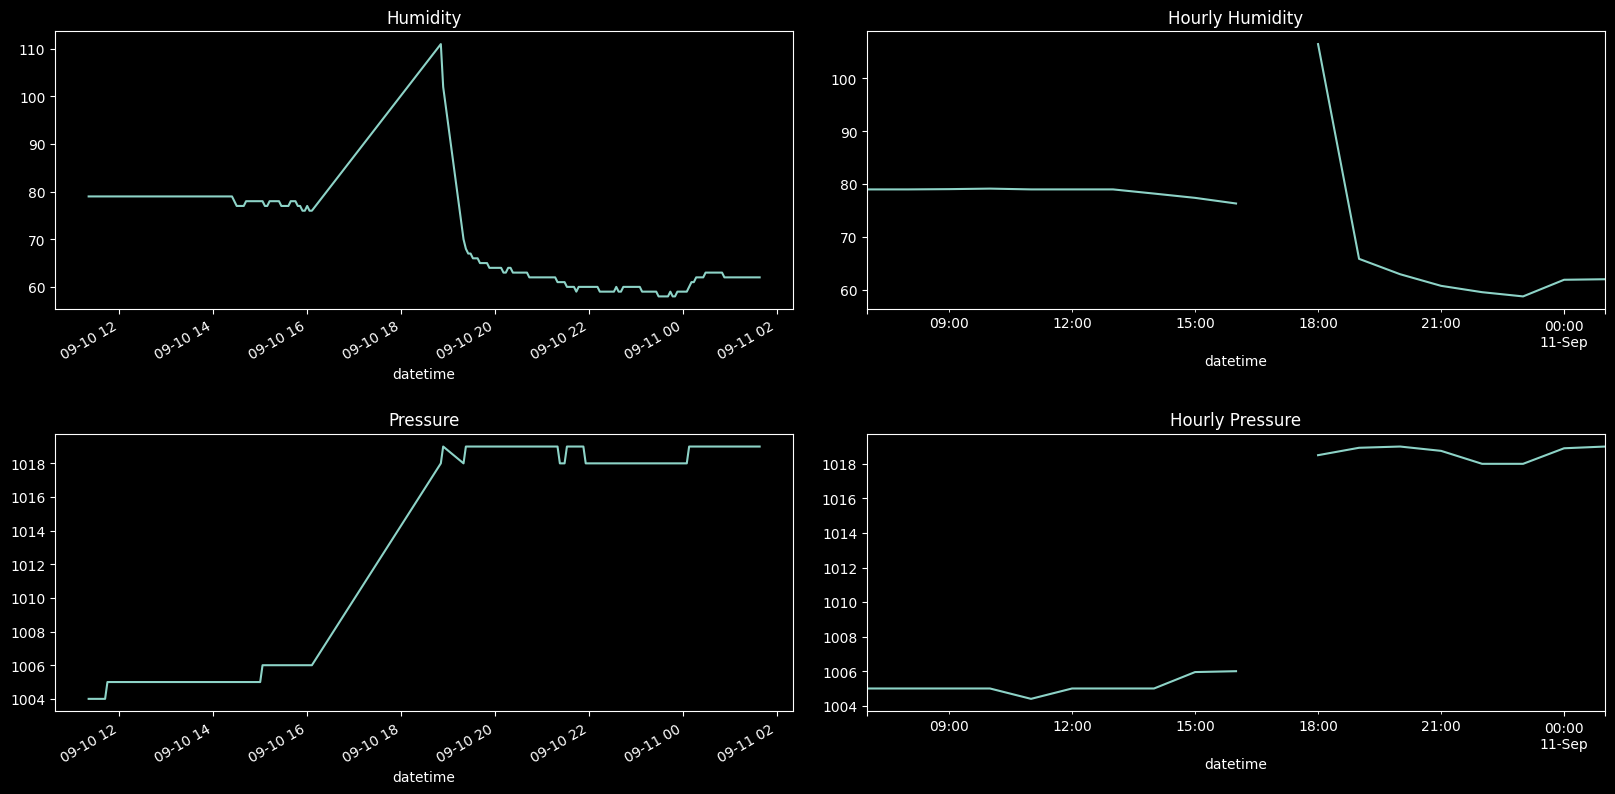

In [29]:
fig, axes = pl.subplots(nrows=2, ncols=2, figsize=(Cw,Ch*2))

logs['humidity'].plot( kind='line', ax=axes[0,0], title="Humidity")
hourly_logs['humidity'].plot( kind='line', ax=axes[0,1], title="Hourly Humidity")

logs['pressure'].plot( kind='line', ax=axes[1,0], title="Pressure")
hourly_logs['pressure'].plot( kind='line', ax=axes[1,1], title="Hourly Pressure")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

### Wave Action ###
----

__Significant Wave Height__: the average height of the highest one-third of the waves measured during the sampling period

__Dominant Wave Period__: the period (=1/frequency) corresponding to highest peak in the wave height frequency spectrum 

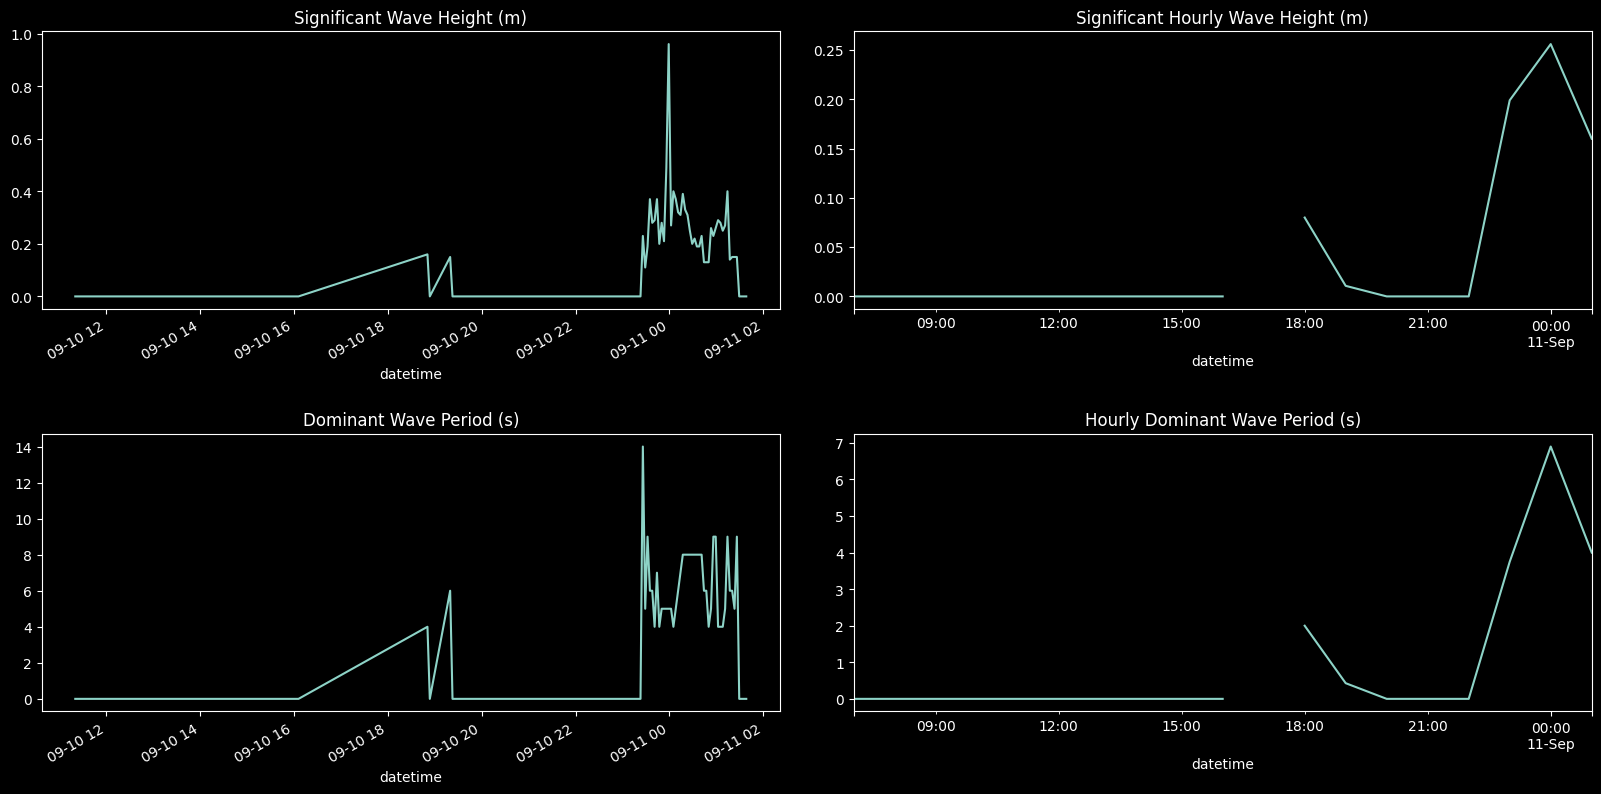

In [28]:
# Draw Charts
fig, axes = pl.subplots(nrows=2, ncols=2, figsize=(Cw,Ch*2))

logs['wave height'].plot( kind='line', ax=axes[0,0], title="Significant Wave Height (m)")
hourly_logs['wave height'].plot( kind='line', ax=axes[0,1], title="Significant Hourly Wave Height (m)")

logs['wave period'].plot( kind='line', ax=axes[1,0], title="Dominant Wave Period (s)")
hourly_logs['wave period'].plot( kind='line', ax=axes[1,1], title="Hourly Dominant Wave Period (s)")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

### Pitch and Roll ###
----
___RMS of Pitch and Roll___:  Root Mean Square (RMS) of sampled pitch and roll angles, in degrees. 

___Maximum Pitch and Roll___:  maximum values recorded during the sampling period, relative to the beam and centerline vertical planes respectively, in degrees. A positive pitch is when the bow is higher than the stern, and a positive roll is when the starboard side is higher than the port side.

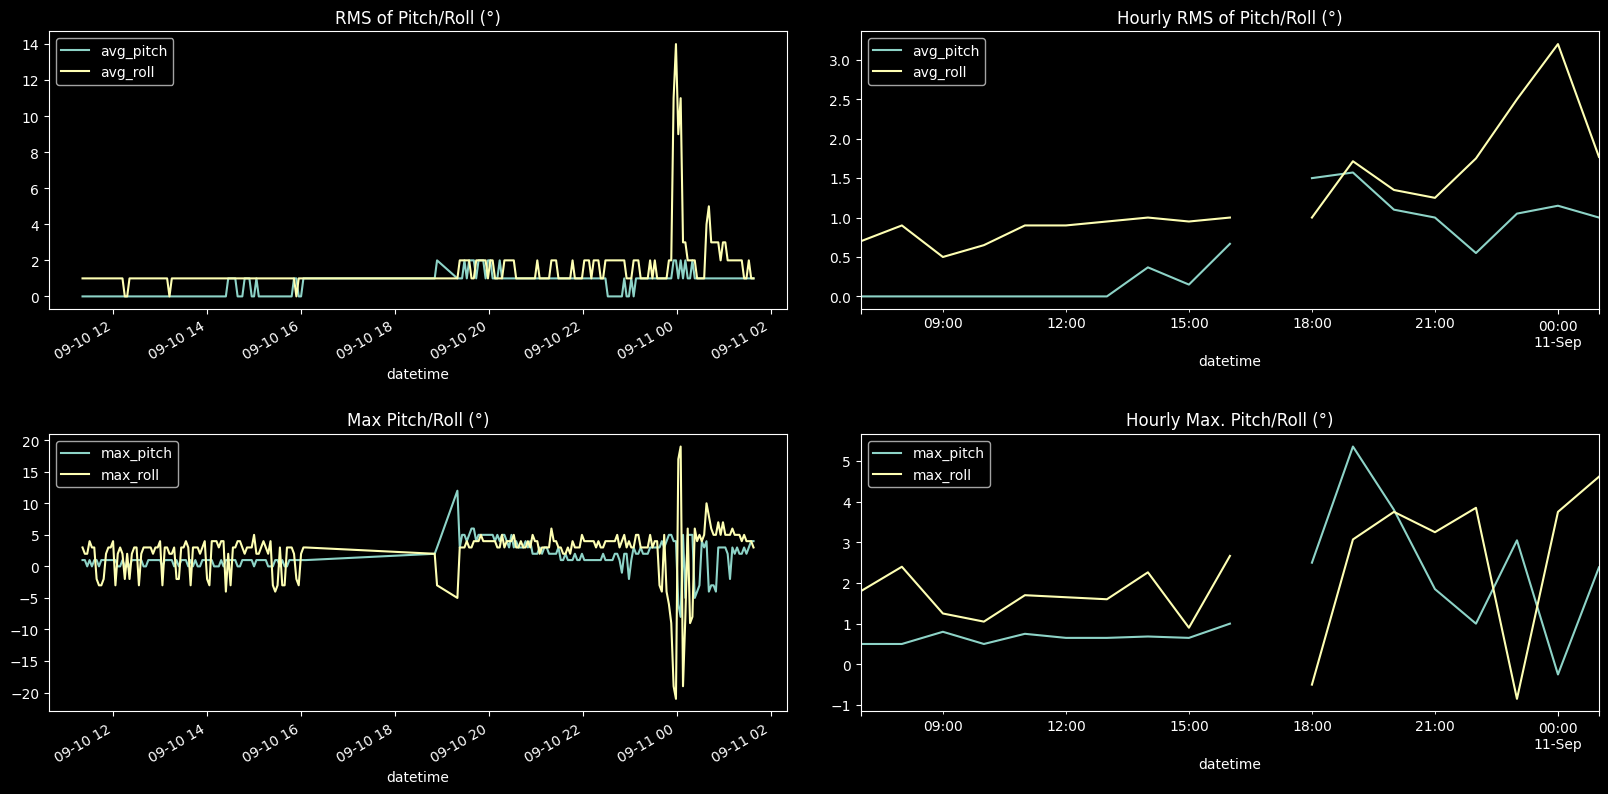

In [27]:
# Draw Charts
fig, axes = pl.subplots(nrows=2, ncols=2, figsize=(Cw,Ch*2))

logs[['avg_pitch', 'avg_roll']].plot( kind='line', ax=axes[0,0], title="RMS of Pitch/Roll (°)")
hourly_logs[['avg_pitch', 'avg_roll']].plot( kind='line', ax=axes[0,1], title="Hourly RMS of Pitch/Roll (°)")

logs[['max_pitch', 'max_roll']].plot( kind='line', ax=axes[1,0], title="Max Pitch/Roll (°)")
hourly_logs[['max_pitch','max_roll']].plot( kind='line', ax=axes[1,1], title="Hourly Max. Pitch/Roll (°)")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

<br>

## NMEA logs ##

In [16]:
# Read CSV and refactor columns
nm_logs = pd.read_csv('log_nmea.csv', index_col = False)
nm_logs["datetime"] = pd.to_datetime(nm_logs["timestamp"], unit="s")
#logs.drop(logs[['timestamp','date', 'time']], axis=1, inplace=True)
#nm_logs = nm_logs[["datetime","lat","lon","sog_kts","cog","hdg","hdg_mag","hdg_true","wind_sp_kts","wind_angle","depth_ft", "depth_m", "water_temp_c"]]
#nm_logs.style.format({'datetime': lambda x: "{}".format(x.strftime('%Y-%m-%d %H:%M:%S'))})
#hourly_nm_logs = nm_logs.resample('h').mean()
nm_logs

,timestamp,lat,lon,sog_kts,cog,hdg,hdg_mag,hdg_true,wind_sp_kts,wind_angle,depth_ft,depth_m,water_temp_c,datetime
0,1.756941e+09,37.516,-122.289,0.000,95,116,116,85,10.33,131,10.33,3.15,0,2025-09-03 23:11:31.134000063
1,1.756941e+09,37.516,-122.289,0.000,353,116,116,85,11.25,134,10.31,3.14,0,2025-09-03 23:12:31.345999956
2,1.756941e+09,37.516,-122.289,0.000,356,116,116,84,15.19,132,14.81,4.51,0,2025-09-03 23:13:31.559000015
3,1.756941e+09,37.516,-122.289,0.000,10,116,116,85,15.69,118,10.50,3.20,0,2025-09-03 23:14:31.565999985
4,1.756941e+09,37.516,-122.289,0.000,11,116,116,84,10.27,123,10.45,3.18,0,2025-09-03 23:15:31.575000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,1.757549e+09,37.490,-122.285,7.746,190,174,174,163,19.46,48,301.49,84.87,3,2025-09-10 23:59:01.528000115
287,1.757549e+09,37.490,-122.286,6.863,285,287,287,312,19.45,324,299.87,22.27,0,2025-09-11 00:00:01.533999919
288,1.757549e+09,37.491,-122.287,7.895,286,285,285,310,19.64,328,274.69,66.67,0,2025-09-11 00:01:01.539000034
289,1.757549e+09,37.491,-122.289,7.331,275,278,278,304,19.33,332,267.89,80.54,0,2025-09-11 00:02:01.543999910


In [17]:
# Index on datetime and aggregate by hour
nm_logs.set_index('datetime', inplace=True)
hourly_nm_logs = nm_logs.resample('h').mean()

In [18]:
# Filter on Datetime
nm_logs = nm_logs[nm_logs.index >= Short_span]
hourly_nm_logs = hourly_nm_logs[hourly_nm_logs.index >= Long_span]

### Wind ###
----

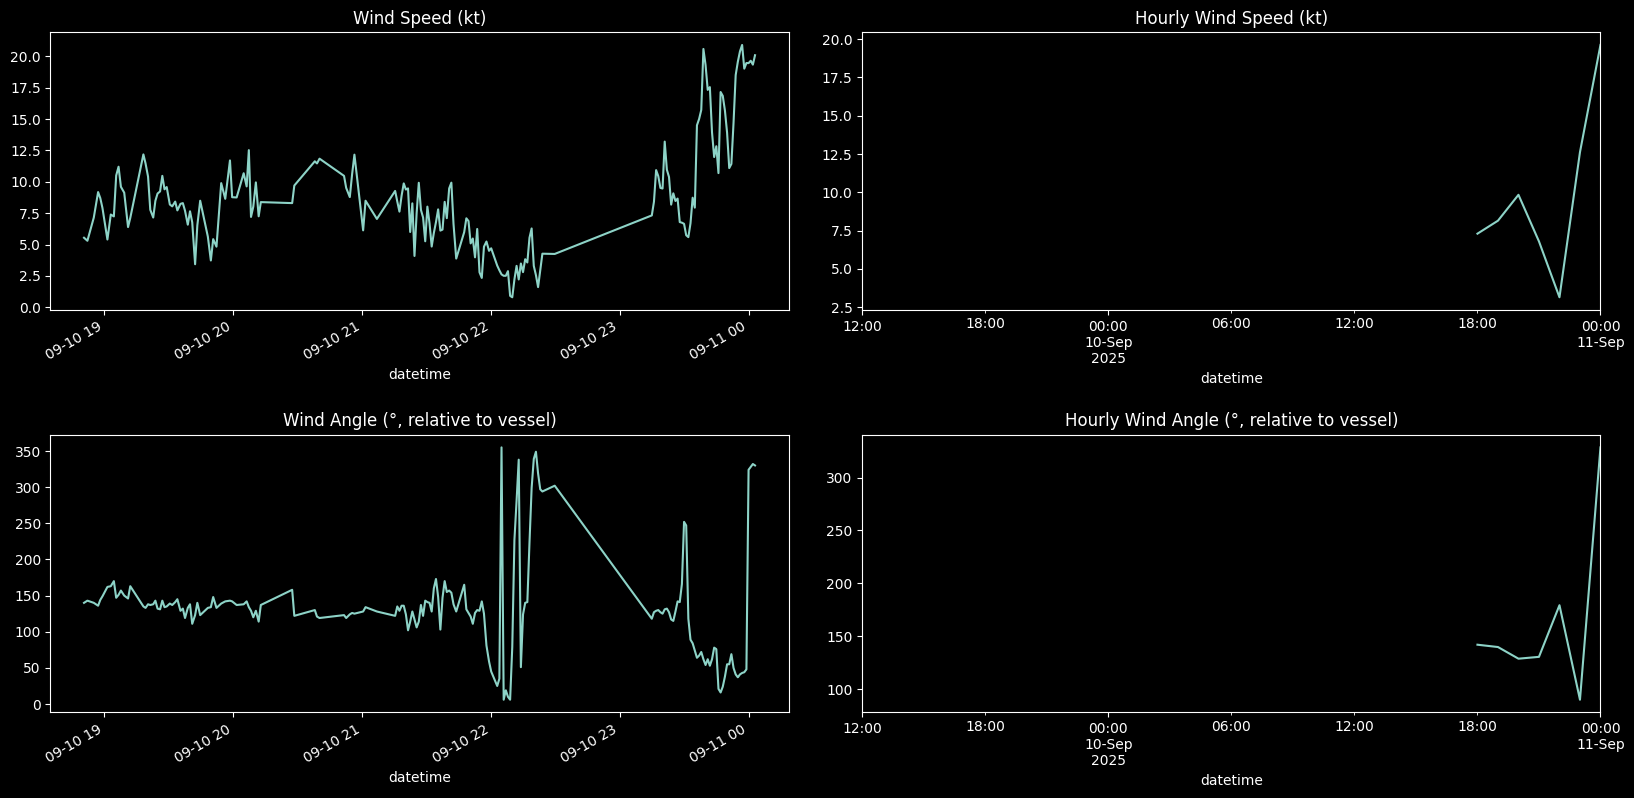

In [26]:
# Draw Charts
fig, axes = pl.subplots(nrows=2, ncols=2, figsize=(Cw,Ch*2))

nm_logs['wind_sp_kts'].plot( kind='line', ax=axes[0,0], title="Wind Speed (kt)")
hourly_nm_logs['wind_sp_kts'].plot( kind='line', ax=axes[0,1], title="Hourly Wind Speed (kt)")

nm_logs['wind_angle'].plot( kind='line', ax=axes[1,0], title="Wind Angle (°, relative to vessel)")
hourly_nm_logs['wind_angle'].plot( kind='line', ax=axes[1,1], title="Hourly Wind Angle (°, relative to vessel)")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

### Depth ###
----

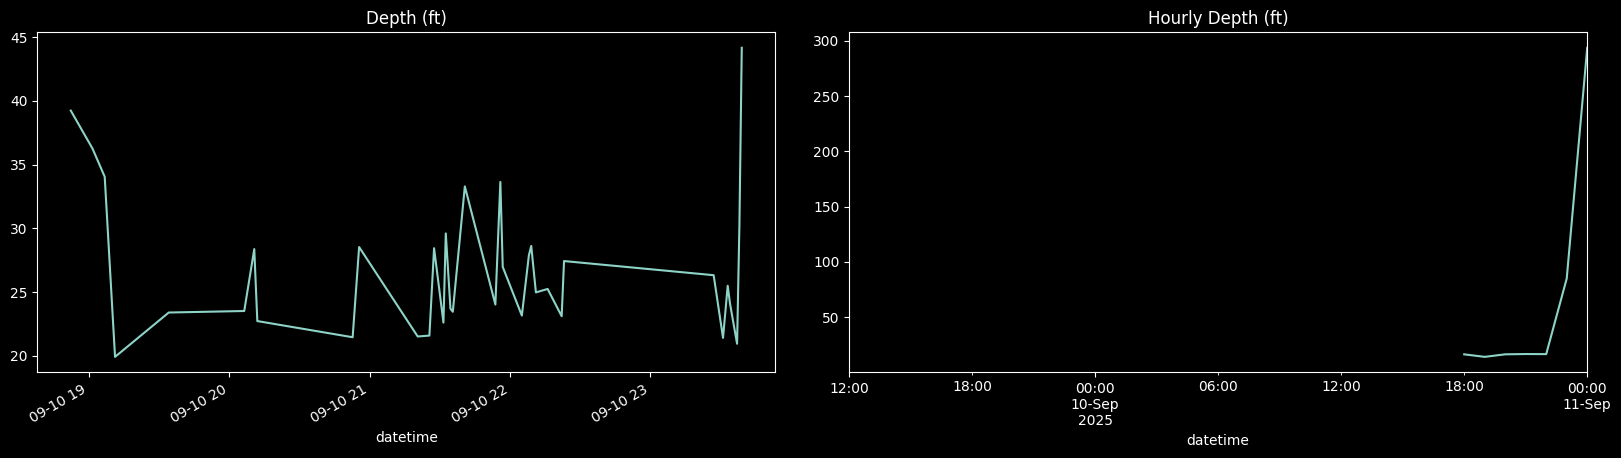

In [25]:
# Draw Charts
fig, axes = pl.subplots(nrows=1, ncols=2, figsize=(Cw,Ch*1))

remove_outliers(nm_logs['depth_ft'], sigma = .3).plot( kind='line', ax=axes[0], title="Depth (ft)")
hourly_nm_logs['depth_ft'].plot( kind='line', ax=axes[1], title="Hourly Depth (ft)")

pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

### Speed, Course and Heading ###

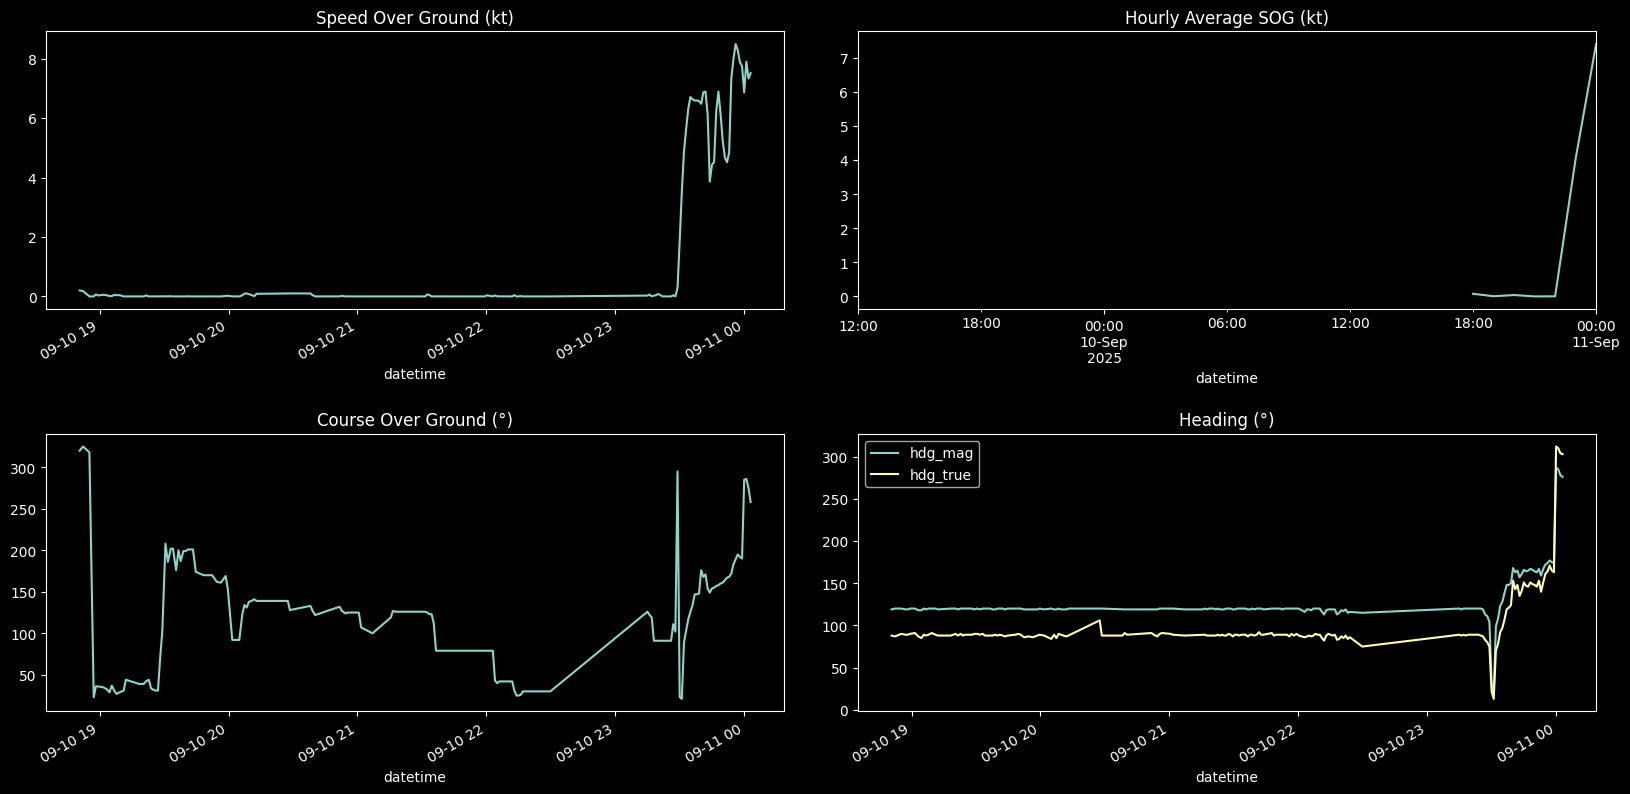

In [24]:
# Draw Charts
fig, axes = pl.subplots(nrows=2, ncols=2, figsize=(Cw,Ch*2))

nm_logs['sog_kts'].plot( kind='line', ax=axes[0,0], title="Speed Over Ground (kt)")
hourly_nm_logs['sog_kts'].plot( kind='line', ax=axes[0,1], title="Hourly Average SOG (kt)")

nm_logs['cog'].plot( kind='line', ax=axes[1,0], title="Course Over Ground (°)")
nm_logs[['hdg_mag', 'hdg_true']].plot( kind='line', ax=axes[1,1], title="Heading (°)")
#nm_logs['hdg_true'].plot( kind='line', ax=axes[2,1], title="Magnetic True")


pl.subplots_adjust(hspace=Hs, wspace=0.1)
pl.show()

## Debugging ##

In [22]:
npydir = 'npyfiles/'
run = '2025_09_02_00_24' # manual simulation of about 1 mt oscillations

In [23]:
freqs    = np.load(f'{npydir}freqs_{run}.npy')
signal   = np.load(f'{npydir}signal_{run}.npy')
amp_spec = np.load(f'{npydir}amp_spec_{run}.npy')
heights  = np.load(f'{npydir}heights_{run}.npy')
print('signal: ', len(signal), 'amp_spec: ', len(amp_spec))

FileNotFoundError: [Errno 2] No such file or directory: 'npyfiles/freqs_2025_09_02_00_24.npy'

In [ ]:
#signal = np.load(f'{npydir}signal_corr.npy')

In [ ]:
w=40
mavg_signal = moving_average(signal,w)
ls =  len(signal)
print(len(signal),len(mavg_signal))

In [ ]:
pl.title('Signal Moving Avg')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(w, ls-w )],mavg_signal[w:ls-w])
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal[0:ls])
pl.show()

subtract moving average from signal to clean low frequencies

In [ ]:
signal_corr = np.concatenate([signal[:w-1], signal[w-1:]-mavg_signal] )

In [ ]:
pl.title('Signal Corr')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal_corr[0:ls])
pl.show()

In [ ]:
np.save(f'{npydir}signal_corr', signal_corr)

In [ ]:
pl.title('Acceleration spectrum')
pl.xlabel('Freq (Hz)')
pl.ylabel('accel (m/sec2)')
pl.plot(freqs, amp_spec)
pl.show()

In [ ]:
w=4
mavg = moving_average(amp_spec, w)
max_index = np.argmax(mavg)+int(w/2)
dom_freq = freqs[max_index]
dom_per = 1/dom_freq
dom_per

In [ ]:
mavg = pl.plot(freqs[3:], mavg)

In [ ]:
pl.title('Displacement Frequency Spectrum')
pl.xlabel('freq (Hz)')
pl.ylabel('height (mt)')
pl.plot(freqs, heights)
pl.show()

In [ ]:
avg_acc = sum(amp_spec)/(len(amp_spec))
avg_acc

In [ ]:
heights[2:]

In [ ]:
max_index = np.argmax(heights[2:])
max_index

Power spectral density

In [ ]:
psd = (heights[2:]**2)/freqs[2:]
psd

In [ ]:
m0  = sum(psd*df)
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

Amplitude Spectral Density

In [ ]:
asd = np.sqrt(psd)

In [ ]:
m0  = sum(asd*df)
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height

#### calculate SWH from time series ####

this makes no sense as it is calculated on acceleration, not displacement

In [ ]:
m0 = np.var(signal)

In [ ]:
sig_wave_height = 4 * math.sqrt(m0) 
sig_wave_height